## Detection of Tuberculosis using X-Ray images

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import pathlib

In [3]:
import os

directory_path = r'C:\Users\HP\OneDrive\Desktop\F_Project\TB\TB_Chest_Radiography_Database'

# List all files in the directory
files = os.listdir(directory_path)

# Print the list of files
for file in files:
    print(file)


Normal
Normal.metadata.xlsx
README.md.txt
TB.ipynb
Tuberculosis
Tuberculosis.metadata.xlsx


In [4]:
import pathlib

data_dir = r'C:\Users\HP\OneDrive\Desktop\F_Project\TB\TB_Chest_Radiography_Database' # Datasets path
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('C:/Users/HP/OneDrive/Desktop/F_Project/TB/TB_Chest_Radiography_Database')

In [5]:
normal = list(data_dir.glob('Normal/*'))
tb = list(data_dir.glob('Tuberculosis/*'))

print("Length of normal: ", len(normal))
print("Length of tb: ", len(tb))

Length of normal:  3500
Length of tb:  700


Print random images

1623
452


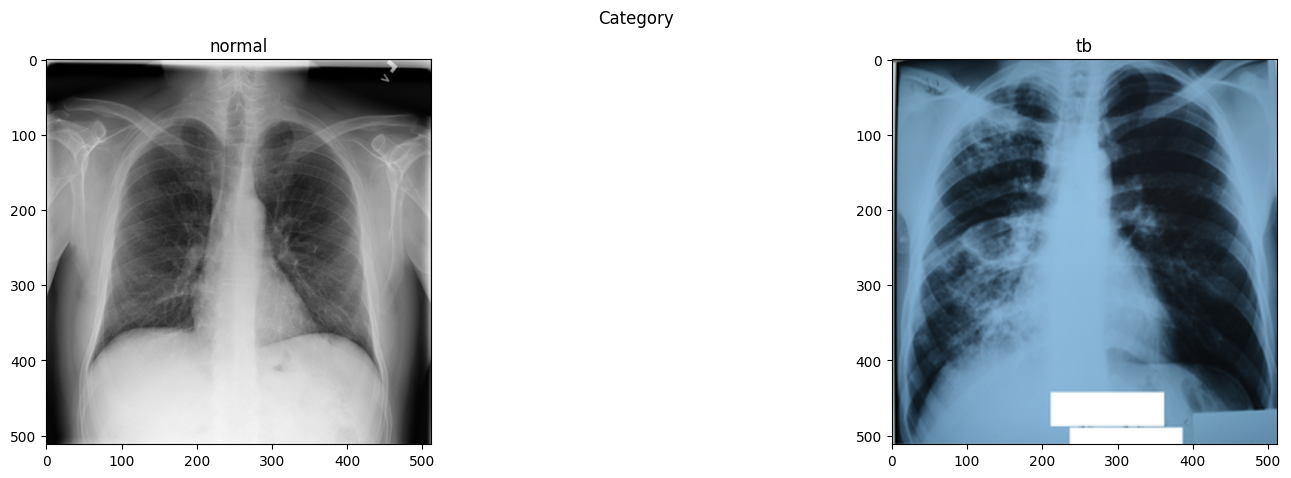

In [6]:
import matplotlib.image as img
import PIL.Image as Image

fig, ax = plt.subplots(ncols= 2, nrows = 1, figsize=(20,5))
fig.suptitle('Category')

rand_normal = np.random.randint(-1,len(normal))
print(rand_normal)

rand_tb = np.random.randint(-1, len(tb))
print(rand_tb)

normal_image = img.imread(normal[rand_normal])
tb_image = img.imread(tb[rand_tb])

ax[0].set_title('normal')
ax[1].set_title('tb')

ax[0].imshow(normal_image)
ax[1].imshow(tb_image)


Define dataframe

In [7]:
# contains the images path

df_images = {
    'normal' : normal,
    'tb' : tb
}

# contains numerical labels for the categories
df_labels = {
    'normal' : 0,
    'tb' : 1
}

Get shape of image

In [8]:
import cv2

img = cv2.imread(str(df_images['tb'][rand_tb])) # Converting it into numerical arrays
img.shape

(512, 512, 3)

Define X and y

In [9]:
X, y = [], [] # X = images, y = labels
for label, images in df_images.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img, (224, 224)) # Resizing the images to be able to pass on MobileNetv2 model
        X.append(resized_img) 
        y.append(df_labels[label])
print(len(X), len(y))

4200 4200


Convert X and y to numpy arrays

In [10]:
X = np.array(X)
y = np.array(y)

Split X and y into training, validation, and testing sets

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, train_size = 0.8, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, random_state=42)
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((3360, 224, 224, 3),
 (210, 224, 224, 3),
 (630, 224, 224, 3),
 (3360,),
 (210,),
 (630,))

Tensorflow

In [12]:
import tensorflow as tf 
from tensorflow import keras 
import tensorflow_hub as hub
from keras.utils.np_utils import to_categorical
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import MobileNetV2, DenseNet169
from keras.callbacks import ModelCheckpoint, EarlyStopping
print(tf.__version__)

2.12.0-rc1


Normalise data

In [13]:
normalizer = tf.keras.layers.Rescaling(scale=1/255)

Define input shape to pretrained models

In [14]:
input_shape = (224, 224, 3)
input_layer = keras.Input(shape = (224, 224, 3))

Set up pretrained models

In [15]:
input_shape = (224, 224, 3)

dense_net = DenseNet169(weights = 'imagenet', input_shape = input_shape,include_top = False)

for layer in dense_net.layers:
    layer.trainable = False

Define model

In [16]:
num_label = len(np.unique(y)) # number of labels

model = keras.Sequential([
    keras.Input(shape=(224,224,3)),
    normalizer,
    dense_net,
    keras.layers.Flatten(),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_label),
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 densenet169 (Functional)    (None, 7, 7, 1664)        12642880  
                                                                 
 flatten (Flatten)           (None, 81536)             0         
                                                                 
 dense (Dense)               (None, 256)               20873472  
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 33,516,866
Trainable params: 20,873,986
No

In [17]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [19]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=25, verbose=1)
mc = ModelCheckpoint ('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

history = model.fit(X_train, y_train, epochs=5, validation_data=(X_val, y_val), callbacks=[early_stopping, mc])

Epoch 1/5
105/105 [==============================] - 594s 6s/step - loss: 0.0556 - acc: 0.9893 - val_loss: 0.0021 - val_acc: 1.0000
Epoch 2/5
105/105 [==============================] - 575s 5s/step - loss: 0.0281 - acc: 0.9932 - val_loss: 0.0223 - val_acc: 0.9952
Epoch 3/5
105/105 [==============================] - 620s 6s/step - loss: 0.0254 - acc: 0.9923 - val_loss: 4.0912e-05 - val_acc: 1.0000
Epoch 4/5
105/105 [==============================] - 653s 6s/step - loss: 0.0267 - acc: 0.9935 - val_loss: 0.0028 - val_acc: 1.0000
Epoch 5/5
105/105 [==============================] - 660s 6s/step - loss: 0.0778 - acc: 0.9893 - val_loss: 0.2342 - val_acc: 0.9524


Make predictions

In [20]:
y_pred = model.predict(X_test, batch_size=64, verbose=1)
y_pred_bool = np.argmax(y_pred, axis=1)
y_pred_bool

10/10 [==============================] - 131s 12s/step


array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,

In [21]:
from sklearn.metrics import accuracy_score

total_right = accuracy_score(y_test, y_pred_bool, normalize=False)
print(total_right)
accuracy = (total_right / len(y_test))
print(accuracy)

612
0.9714285714285714


In [22]:
model.evaluate(X_test,y_test)

20/20 [==============================] - 104s 5s/step - loss: 0.1243 - acc: 0.9714


[0.12431840598583221, 0.9714285731315613]

In [23]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_bool))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98       527
           1       0.85      1.00      0.92       103

    accuracy                           0.97       630
   macro avg       0.93      0.98      0.95       630
weighted avg       0.98      0.97      0.97       630



In [24]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_pred_bool)

array([[509,  18],
       [  0, 103]], dtype=int64)

In [25]:
df = pd.DataFrame({'actual': y_test, 'predicted': y_pred_bool})
df

,actual,predicted
0,0,0
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
625,1,1
626,0,0
627,0,0
628,0,0


In [26]:
from plotly.offline import iplot, init_notebook_mode
import plotly.express as px

init_notebook_mode(connected=True)

acc = pd.DataFrame({'train': history.history['acc'], 'val': history.history['val_acc']})

fig = px.line(acc, x=acc.index, y=acc.columns[0::], title='Training and Evaluation Accuracy every Epoch', markers=True)
fig.show()

In [27]:
loss = pd.DataFrame({'train': history.history['loss'], 'val': history.history['val_loss']})

fig = px.line(loss, x=loss.index, y=loss.columns[0::], title='Training and Evaluation Loss every Epoch', markers=True)
fig.show()